In [64]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [65]:
%%bash
cd .. && make clean && make

In [66]:
config_name = 'constant'
conf = load_conf(config_name)
final_temp_th = (lambda r: conf['S0'] / (4 * conf['kappa0']) * (conf['R']**2 - r**2) + conf['TR'])(0)
final_heat_th = (lambda r: conf['S0'] / 2 * r)(conf['R'])
final_heat_th

25.0

In [67]:
def s(r):
    return conf['S0'] * np.exp(-(r - conf['r0'])**2 / (conf['sigma']**2))

In [68]:
S0 = conf['S0']
r0 = conf['r0']
sigma = conf['sigma']
R = conf['R']

def dPtot(r):
    return 2*np.pi*r * S0*np.exp(-((r-r0)/sigma)**2)

Ptot = sc.integrate.quad(dPtot, 0, R)[0]

In [69]:
N = np.linspace(10, 1000, 200, dtype=int)
data_unif = run_with_params(
    config_name,
    gen_variations({
        'alpha': [1],
        'N': N
    })
)
data_nonunif = run_with_params(
    config_name,
    gen_variations({
        'alpha': [2],
        'N': N
    })
)

Running simulations... Done 200/200
Running simulations... Done 200/200


# Plots!

In [70]:
error_final_temp_unif = np.zeros(len(N))
unif_max_interval = np.zeros(len(N))
error_final_temp_nonunif = np.zeros(len(N))
nonunif_max_interval = np.zeros(len(N))
for i, (params, temp, heat) in enumerate(data_unif):
    error_final_temp_unif[i] = abs(temp[0,1] - final_temp_th)
    unif_max_interval[i] = np.max(np.diff(temp[:,0]))

for i, (params, temp, heat) in enumerate(data_nonunif):
    error_final_temp_nonunif[i] = abs(temp[0,1] - final_temp_th)
    nonunif_max_interval[i] = np.max(np.diff(temp[:,0]))

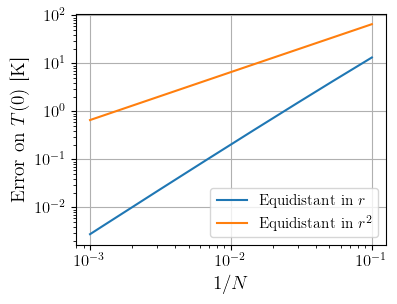

In [71]:
plt.loglog(1/N, error_final_temp_unif, '-', label='Equidistant in $r$')
plt.loglog(1/N, error_final_temp_nonunif, '-', label='Equidistant in $r^2$')

plt.xlabel(r'$1/N$')
plt.ylabel(r'Error on $T(0)$ [K]')
plt.legend()
plt.grid()

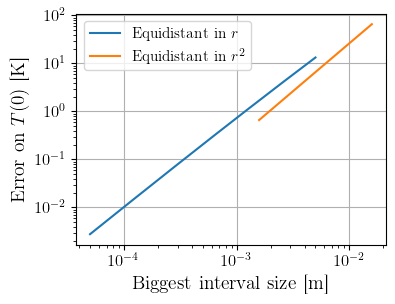

In [72]:
plt.loglog(unif_max_interval, error_final_temp_unif, '-', label='Equidistant in $r$')
plt.loglog(nonunif_max_interval, error_final_temp_nonunif, '-', label='Equidistant in $r^2$')

plt.xlabel(r'Biggest interval size [m]')
plt.ylabel(r'Error on $T(0)$ [K]')
plt.legend()
plt.grid()

## Turn up the heat

In [76]:
error_final_heat_unif = np.zeros(len(N))
error_balance_unif = np.zeros(len(N))
error_final_heat_nonunif = np.zeros(len(N))
error_balance_nonunif = np.zeros(len(N))
for i, (params, temp, heat) in enumerate(data_unif):
    error_final_heat_unif[i] = abs(heat[-1,1] - final_heat_th)
    gamma_Q = 2 * np.pi * heat[-1,0] * heat[-1,1]
    error_balance_unif[i] = abs(gamma_Q - Ptot)

for i, (params, temp, heat) in enumerate(data_nonunif):
    error_final_heat_nonunif[i] = abs(heat[-1,1] - final_heat_th)
    gamma_Q = 2 * np.pi * heat[-1,0] * heat[-1,1]
    error_balance_nonunif[i] = abs(gamma_Q - Ptot)

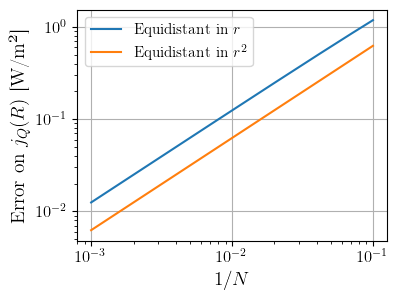

In [77]:
plt.loglog(1/N, error_final_heat_unif, '-', label='Equidistant in $r$')
plt.loglog(1/N, error_final_heat_nonunif, '-', label='Equidistant in $r^2$')

plt.xlabel(r'$1/N$')
plt.ylabel(r'Error on $j_Q(R)$ [W/m²]')
plt.legend()
plt.grid()

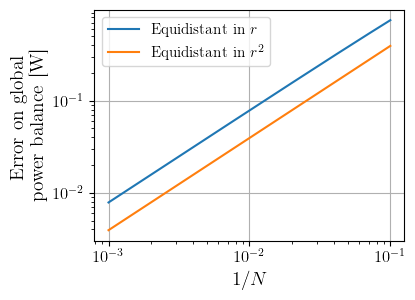

In [81]:
plt.loglog(1/N, error_balance_unif, '-', label='Equidistant in $r$')
plt.loglog(1/N, error_balance_nonunif, '-', label='Equidistant in $r^2$')

plt.xlabel(r'$1/N$')
plt.ylabel(r'Error on global\\power balance [W]')
plt.legend()
plt.grid()